## Homework

1. In this notebook, we learned the various components of an LLM. 
    Your homework this week is to take the mini LLM we created from scratch and run your own training loop. Show how the training and validation perplexity change over the steps.
      
    Hint: this function might be useful for you:

In [1]:
import os
os.environ["HTTP_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["HTTPS_PROXY"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["http_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["https_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128"
os.environ["ftp_proxy"]="http://proxy-01.pub.alcf.anl.gov:3128" 

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel? #default=16
block_size = 32 # what is the maximum context length for predictions?   #default=32
max_iters = 5000    
eval_interval = 10
learning_rate = 1e-3    #default=1e-3
device = 'cuda' if torch.cuda.is_available() else 'mps'
# device = 'cpu'
# device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}")
eval_iters = 200
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4
dropout = 0.0
# ------------

Using device mps


In [3]:
with open('dataset/input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.7*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# print(train_data)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [4]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C) 16,32,16
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd), # Projection layer going back into the residual pathway
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


In [5]:
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))    # Communication
        x = x + self.ffwd(self.ln2(x))  # Computation
        return x

In [6]:
# super simple language model
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx



In [7]:
model = LanguageModel()
# model.to(device)
# model.eval()

In [8]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.to(device)
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            # X, Y = X.to(device), Y.to(device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [9]:
from tqdm.notebook import tqdm

loss_his = {'train':[], 'val':[]}

epochs = 30
for j in range(epochs):
    out = estimate_loss()
    train_loss, val_loss = out['train'], out['val']
    loss_his['train'].append(train_loss)
    loss_his['val'].append(val_loss)

    print(f"Epoch {j}: train loss: {train_loss:.3f}, validation loss: {val_loss:.3f}")

Epoch 0: train loss: 4.307, validation loss: 4.308
Epoch 1: train loss: 4.304, validation loss: 4.304
Epoch 2: train loss: 4.304, validation loss: 4.308
Epoch 3: train loss: 4.303, validation loss: 4.308
Epoch 4: train loss: 4.301, validation loss: 4.305
Epoch 5: train loss: 4.303, validation loss: 4.304
Epoch 6: train loss: 4.302, validation loss: 4.307
Epoch 7: train loss: 4.306, validation loss: 4.305
Epoch 8: train loss: 4.301, validation loss: 4.307
Epoch 9: train loss: 4.306, validation loss: 4.307
Epoch 10: train loss: 4.305, validation loss: 4.304
Epoch 11: train loss: 4.303, validation loss: 4.308
Epoch 12: train loss: 4.304, validation loss: 4.308
Epoch 13: train loss: 4.305, validation loss: 4.306
Epoch 14: train loss: 4.305, validation loss: 4.306
Epoch 15: train loss: 4.304, validation loss: 4.306
Epoch 16: train loss: 4.305, validation loss: 4.301
Epoch 17: train loss: 4.305, validation loss: 4.304
Epoch 18: train loss: 4.304, validation loss: 4.306
Epoch 19: train loss: 

Text(0.5, 1.0, 'train loss vs validation loss')

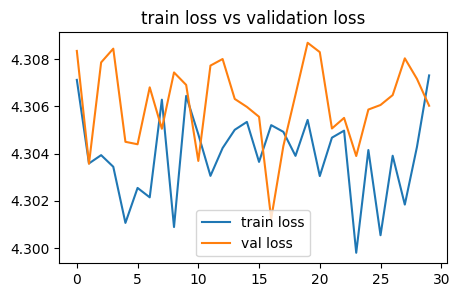

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,3))
plt.plot(loss_his['train'],label='train loss')
plt.plot(loss_his['val'],label='val loss')
plt.legend()
plt.title('train loss vs validation loss')

In [11]:
# hyperparameters
n_embd = 64
n_head = 4 ## so head_size = 16
n_layer = 4

In [12]:
import optuna

def objective(trial):

    n_embd = trial.suggest_int("n_embd", 1,256, step=2)
    n_head = trial.suggest_int("n_head", 1,62, step=2)
    n_layer = trial.suggest_int("n_layer", 1,62, step=2)
    
    model = LanguageModel()
    model.to(device)
    
    #validation_loss = estimate_loss()['val']
    #return validation_loss

    return train_loss + val_loss
    
search_space = {"n_embd": [1, 256], "n_head": [1, 62], "n_layer": [1, 62]}

#study = optuna.create_study(direction="minimize")
study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective, n_trials=100)
    
trial = study.best_trial

print("Loss: {}".format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

[I 2024-04-07 00:26:39,343] A new study created in memory with name: no-name-46a302d3-e09e-4088-b496-1c92ff27580d
/Users/justinxie/miniconda3/envs/pytorch/lib/python3.8/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 256] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 255].
  warnings.warn(
/Users/justinxie/miniconda3/envs/pytorch/lib/python3.8/site-packages/optuna/samplers/_grid.py:198: UserWarning: The value `256` is out of range of the parameter `n_embd`. The value will be used but the actual distribution is: `IntDistribution(high=255, log=False, low=1, step=2)`.
  warnings.warn(
/Users/justinxie/miniconda3/envs/pytorch/lib/python3.8/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [1, 62] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 61].
  warnings.warn(
/Users/justinxie/miniconda3/envs/pytorch/lib/python3.8/site-packages/optuna/

Loss: 8.613336563110352
Best hyperparameters: {'n_embd': 256, 'n_head': 1, 'n_layer': 62}


In [13]:
# hyperparameters
n_embd = trial.params['n_embd']
n_head = trial.params['n_head']
n_layer = trial.params['n_layer']

model = LanguageModel()
# model.to(device)

Epoch 0: train loss: 4.300, validation loss: 4.298
Epoch 1: train loss: 4.295, validation loss: 4.298
Epoch 2: train loss: 4.297, validation loss: 4.296
Epoch 3: train loss: 4.296, validation loss: 4.299
Epoch 4: train loss: 4.297, validation loss: 4.298
Epoch 5: train loss: 4.293, validation loss: 4.297
Epoch 6: train loss: 4.294, validation loss: 4.296
Epoch 7: train loss: 4.298, validation loss: 4.296
Epoch 8: train loss: 4.299, validation loss: 4.296
Epoch 9: train loss: 4.295, validation loss: 4.300
Epoch 10: train loss: 4.294, validation loss: 4.297
Epoch 11: train loss: 4.297, validation loss: 4.298
Epoch 12: train loss: 4.299, validation loss: 4.296
Epoch 13: train loss: 4.294, validation loss: 4.299
Epoch 14: train loss: 4.297, validation loss: 4.296
Epoch 15: train loss: 4.299, validation loss: 4.297
Epoch 16: train loss: 4.295, validation loss: 4.301
Epoch 17: train loss: 4.295, validation loss: 4.300
Epoch 18: train loss: 4.296, validation loss: 4.298
Epoch 19: train loss: 

Text(0.5, 1.0, 'train loss vs validation loss')

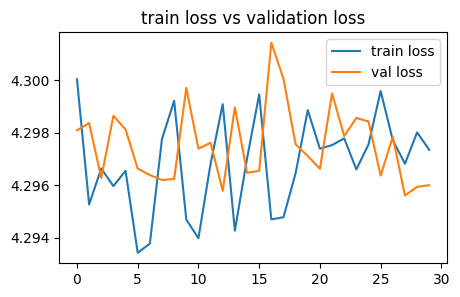

In [14]:
import matplotlib.pyplot as plt


loss_his = {'train':[], 'val':[]}

epochs = 30
for j in range(epochs):
    out = estimate_loss()
    train_loss, val_loss = out['train'], out['val']
    loss_his['train'].append(train_loss)
    loss_his['val'].append(val_loss)

    print(f"Epoch {j}: train loss: {train_loss:.3f}, validation loss: {val_loss:.3f}")
    


plt.figure(figsize=(5,3))
plt.plot(loss_his['train'],label='train loss')
plt.plot(loss_his['val'],label='val loss')
plt.legend()
plt.title('train loss vs validation loss')